In [13]:
import sys
if sys.path[0] != '/mnt/home/landerson/.local/lib/python3.6/site-packages':
    sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages/astroML-0.3-py3.6.egg')
    sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages/xdgmm-1.0.9-py3.6.egg') 
    sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib as mpl
from scipy import stats
from dustmaps.sfd import SFDQuery
from dustmaps.bayestar import BayestarQuery
import astropy.coordinates as coord
import astropy.units as u
import scipy.stats
from astropy.table import Table, unique, Column, hstack, vstack
import healpy as hp
from xdgmm import XDGMM
import GPdust
import scipy.optimize as op
import emcee

In [21]:
color, absmag, colorErr, absmagErr, ra, dec, parallax = GPdust.get_arrays()

X, Xerr = GPdust.matrixize(color, absmag, colorErr, absmagErr)
ncomp = 64
try:
    xdgmm = XDGMM(filename='rjce_lowdust_{0}G.fits'.format(ncomp))
except IOError:
    xdgmm = XDGMM(method='Bovy')
    xdgmm.n_components = ncomp
    xdgmm = xdgmm.fit(X, Xerr)
    xdgmm.save_model('rjce_lowdust_{0}G.fits'.format(ncomp))

m = 0
n = 10
nthreads = 5


hw2 = np.zeros((n-m, 3))
mw2 = np.zeros((n-m, 3))
Ak  = np.zeros((n-m, 3))


In [22]:
sample = xdgmm.sample(len(color))

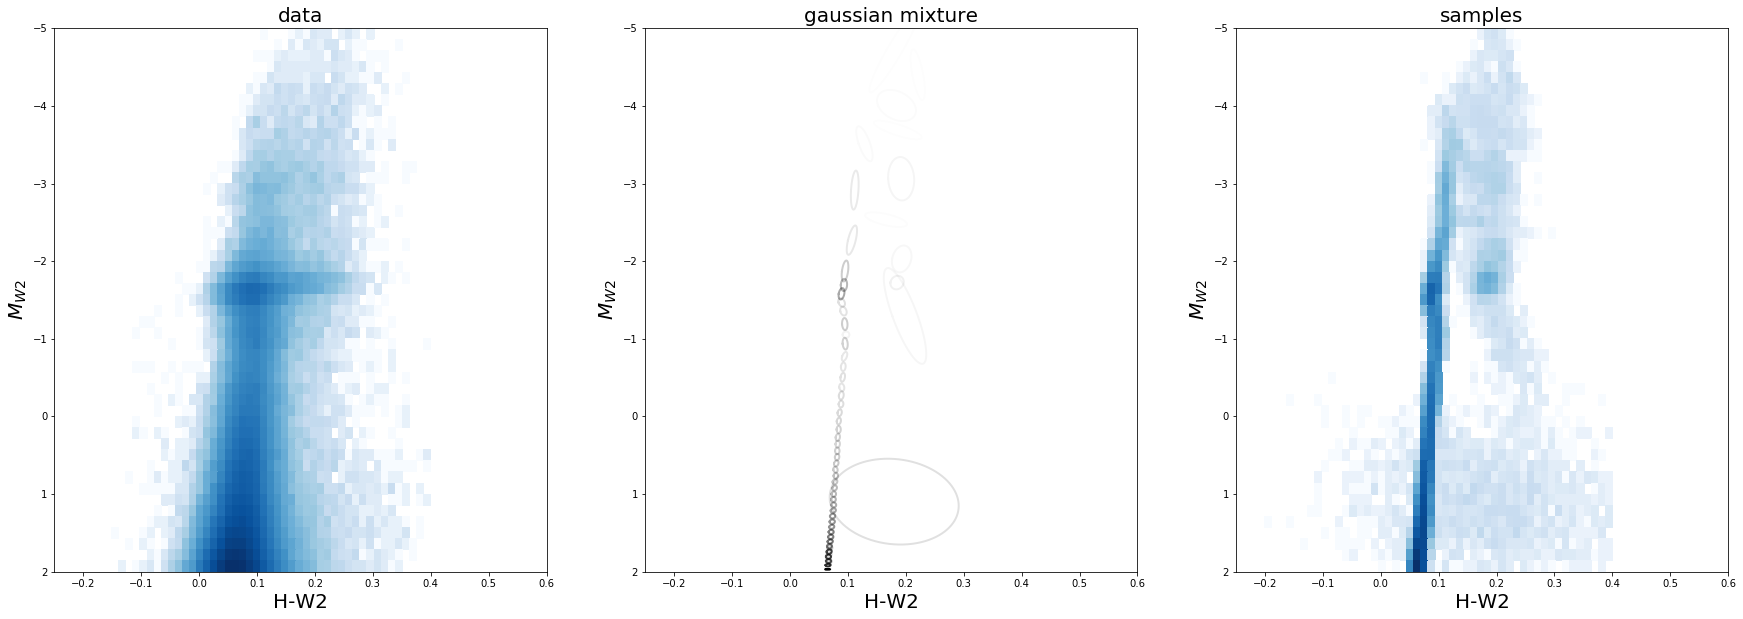

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

nbins = 50
xbins = np.linspace(-0.2, 0.4, nbins)
ybins = np.linspace(-5, 2, nbins)

for c, ab, a in zip([color, sample[:,0]], [absmag, sample[:,1]], [ax[0], ax[2]]):
    H, xe, ye = np.histogram2d(c, 
                           ab, 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)

GPdust.plotXdgmm(xdgmm, ax[1], lw=2)

labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('H-W2', fontsize=20)
    a.set_ylabel('$M_{W2}$', fontsize=20)
    a.set_xlim(-0.25, 0.6)
    a.set_ylim(2, -5)
    a.set_title(l, fontsize=20)


0
1
2
3
4
5
6
7
8
9
[[0.06692847 0.0043188  0.0043539 ]
 [0.07824105 0.15690665 0.00749085]
 [0.06704317 0.00433479 0.00418429]
 [0.1263565  0.12078903 0.06624084]
 [0.07760327 0.12083136 0.00549509]
 [0.06938257 0.00449686 0.00404088]
 [0.17398354 0.08997361 0.10498177]
 [0.07403386 0.00470169 0.00472556]
 [0.07355212 0.15473044 0.00699996]
 [0.06993695 0.00409949 0.00474808]] [[1.83489484e+00 1.84146974e-03 1.78798218e-03]
 [1.27055853e+00 6.18605548e-02 3.37365884e-03]
 [1.79262225e+00 1.70465721e-03 1.69901509e-03]
 [2.01386690e+00 4.69902870e-02 2.70299821e-02]
 [1.02318532e+00 4.78012502e-02 2.28682629e-03]
 [1.61207369e+00 1.85691060e-03 1.78100488e-03]
 [2.05051538e+00 3.52192241e-02 4.15865749e-02]
 [1.32997247e+00 2.00397003e-03 1.95602407e-03]
 [1.63381044e+00 6.10848177e-02 3.25483731e-03]
 [1.60475030e+00 1.77300103e-03 1.95628765e-03]] [[ 0.02572987  0.00403027  0.00407229]
 [ 0.03538122  0.00736548  0.14385092]
 [-0.01747078  0.003696    0.00396358]
 [-0.08768239  0.0610

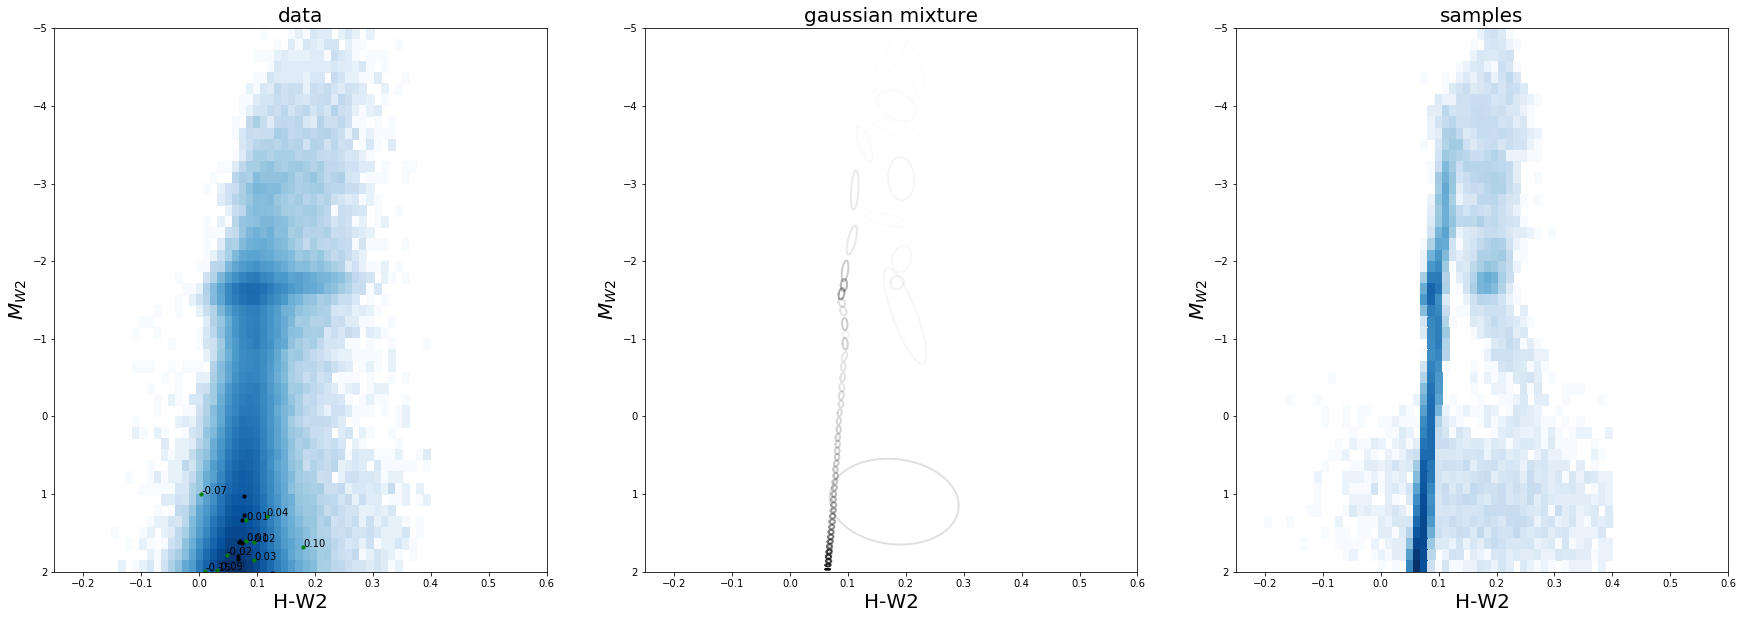

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

nbins = 50
xbins = np.linspace(-0.2, 0.4, nbins)
ybins = np.linspace(-5, 2, nbins)

for c, ab, a in zip([color, sample[:,0]], [absmag, sample[:,1]], [ax[0], ax[2]]):
    H, xe, ye = np.histogram2d(c, 
                           ab, 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)

GPdust.plotXdgmm(xdgmm, ax[1], lw=2)

labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('H-W2', fontsize=20)
    a.set_ylabel('$M_{W2}$', fontsize=20)
    a.set_xlim(-0.25, 0.6)
    a.set_ylim(2, -5)
    a.set_title(l, fontsize=20)

for i in np.arange(m, n):
    print(i)
    Y, Y_err = GPdust.matrixize(color[i],
                         absmag[i],
                         colorErr[i],
                         absmagErr[i])
    Ak_guess = 0.01
    hw2_guess = color[i]
    mw2_guess = absmag[i]
    result = op.minimize(GPdust.nlp, [hw2_guess, mw2_guess, Ak_guess],
                 args=(Y, Y_err, xdgmm))

    ndim, nwalkers = 3, 50
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, GPdust.lnprob, args=(Y, Y_err, xdgmm), threads=nthreads)
    sampler.run_mcmc(pos, 200)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

    hw2_mcmc, mw2_mcmc, ak_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                      zip(*np.percentile(samples, [16, 50, 84],
                                                         axis=0)))
    hw2[i-m] = hw2_mcmc
    mw2[i-m] = mw2_mcmc
    Ak[i-m] = ak_mcmc
    ax[0].scatter(hw2_mcmc[0], mw2_mcmc[0], s=10, c='black')
    ax[0].scatter(hw2_guess, mw2_guess, s=10, c='green')
    ax[0].annotate('{0:.2f}'.format(ak_mcmc[0]), [hw2_guess, mw2_guess])
np.savez('posteriorSamples_{0}_{1}'.format(n, m), hw2=hw2, mw2=mw2, Ak=Ak, ra=ra, dec=dec, parallax=parallax)

print(hw2, mw2, Ak)


In [16]:
I = np.zeros((1, 2, 2))

In [19]:
xdgmm = XDGMM(filename='rjce_lowdust_64G.fits')
%timeit xdgmm.score_samples(np.vstack([0.1, 1]).T, I)

2.04 ms ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
xdgmm = XDGMM(filename='rjce_lowdust_256G.fits')
%timeit xdgmm.score_samples(np.vstack([0.1, 1]).T, I)

6.55 ms ± 76.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
